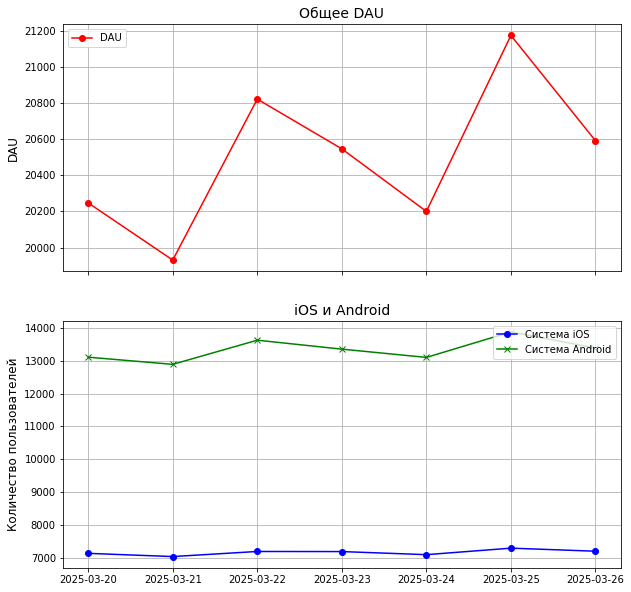

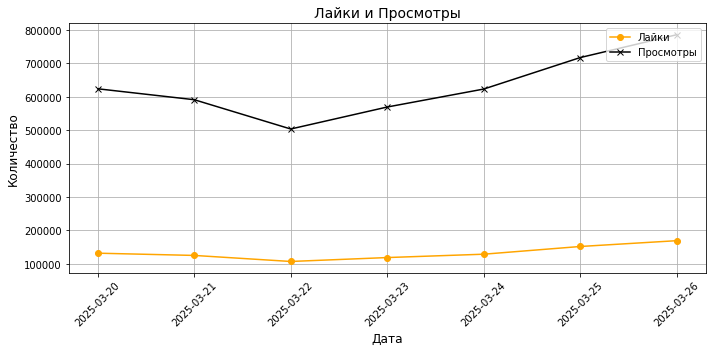

In [6]:
import telegram
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging

from datetime import datetime, timedelta
import pandahouse as ph
from io import BytesIO
import requests

#from airflow.decorators import dag, task
#from airflow.operators.python import get_current_context

# настройка взаимодействия с ботом
#chat_id = -938659451
chat_id = 908660065
my_token = '7680117939:AAFmoIXFfxF8ruzwtiZxg37OIH9jTpBZCHw'
bot = telegram.Bot(token=my_token)

# подключаемся к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database': 'simulator_20250220',
    'user': 'student',
    'password': 'dpo_python_2020'
}

# дефолтные параметры DAG
default_args = {
    'owner': 's_zizevskij',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
    'start_date': datetime(2025, 3, 24),
}

schedule_interval = '0 11 * * *'

#@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False)
def auto_report_zas():
    
    #@task()
    #def get_dau_data():
    def extract_dau():
        q1 = """
            SELECT date, uniqExact(user_id) AS DAU, 
                   uniqExactIf(user_id, os='iOS') AS iOS, 
                   uniqExactIf(user_id, os='Android') AS Android
            FROM (
                SELECT toDate(time) AS date, user_id, os
                FROM simulator_20250220.feed_actions
                UNION ALL
                SELECT toDate(time) AS date, user_id, os
                FROM simulator_20250220.message_actions
            ) AS merged
            WHERE date BETWEEN toDate(now()) - 7 AND toDate(now()) - 1
            GROUP BY date
            ORDER BY date
            """
        return ph.read_clickhouse(q1, connection=connection)

    #@task()
    #def get_actions_data():
    def extract_action():
        q2 = """
            SELECT date, likes, views, CTR, messages 
            FROM (
                SELECT toDate(time) AS date,  
                       countIf(action='like') AS likes, 
                       countIf(action='view') AS views,
                       ROUND(countIf(action='like')/countIf(action='view'), 2) AS CTR
                FROM simulator_20250220.feed_actions
                WHERE date BETWEEN toDate(now()) - 7 AND toDate(now()) - 1
                GROUP BY toDate(time)) AS t1
            INNER JOIN
                (SELECT toDate(time) AS date, 
                        COUNT(user_id) AS messages
                 FROM simulator_20250220.message_actions
                 WHERE date BETWEEN toDate(now()) - 7 AND toDate(now()) - 1
                 GROUP BY toDate(time)) AS t2 
            ON t1.date = t2.date
            ORDER BY date
            """
        return ph.read_clickhouse(q2, connection=connection)

    #@task()
    #def generate_report(dau, actions):
    def report(dau, actions):
        # расчет изменений
        dau_change_percentage = dau.loc[6, 'DAU'] / dau.loc[5, 'DAU'] - 1
        ios_change_percentage = dau.loc[6, 'iOS'] / dau.loc[5, 'iOS'] - 1
        android_change_percentage = dau.loc[6, 'Android'] / dau.loc[5, 'Android'] - 1
        likes_change_percentage = actions.loc[6, 'likes'] / actions.loc[5, 'likes'] - 1
        views_change_percentage = actions.loc[6, 'views'] / actions.loc[5, 'views'] - 1
        ctr_change_percentage = actions.loc[6, 'CTR'] / actions.loc[5, 'CTR'] - 1

        # текст для отправки в телеграм
        message = f"Отчёт по показателям на {datetime.now().strftime('%d-%m-%Y')}:\n\n" \
                  f"DAU = {dau.loc[6, 'DAU']} ({dau_change_percentage:.2%} )\n" \
                  f"Система iOS  = {dau.loc[6, 'iOS']} ({ios_change_percentage:.2%} )\n" \
                  f"Система Android = {dau.loc[6, 'Android']} ({android_change_percentage:.2%})\n" \
                  f"Лайки = {actions.loc[6, 'likes']} ({likes_change_percentage:.2%})\n" \
                  f"Просмотры = {actions.loc[6, 'views']} ({views_change_percentage:.2%} )\n" \
                  f"CTR = {actions.loc[6, 'CTR']} ({ctr_change_percentage:.2%})"
        logging.info(message)  # Логируем сообщение

        # подготовка данных для графиков
        dates = dau['date']
        dau_values = dau['DAU']
        ios_values = dau['iOS']
        android_values = dau['Android']
        likes_values = actions['likes']
        views_values = actions['views']

        # создаем графики
        fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

        # График общего DAU
        axes[0].plot(dates, dau_values, marker='o', linestyle='-', color='red', label='DAU')
        axes[0].set_title('Общее DAU', fontsize=14)
        axes[0].set_ylabel('DAU', fontsize=12)
        axes[0].legend(loc='upper left')
        axes[0].grid(True)

        # график пользователей по платформам
        axes[1].plot(dates, ios_values, marker='o', linestyle='-', color='blue', label='Система iOS')
        axes[1].plot(dates, android_values, marker='x', linestyle='-', color='green', label='Система Android')
        axes[1].set_title('iOS и Android', fontsize=14)
        axes[1].set_ylabel('Количество пользователей', fontsize=12)
        axes[1].legend(loc='upper right')
        axes[1].grid(True)

        # Отправляем график 1
        buf1 = BytesIO()
        plt.savefig(buf1, format='png')
        buf1.seek(0)
        bot.send_photo(chat_id=chat_id, photo=buf1)
        buf1.close()

        # график лайков и просмотров
        plt.figure(figsize=(10, 5))
        plt.plot(dates, likes_values, marker='o', linestyle='-', color='orange', label='Лайки')
        plt.plot(dates, views_values, marker='x', linestyle='-', color='black', label='Просмотры')
        plt.title('Лайки и Просмотры', fontsize=14)
        plt.xlabel('Дата', fontsize=12)
        plt.ylabel('Количество', fontsize=12)
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Отправляем график 2
        buf2 = BytesIO()
        plt.savefig(buf2, format='png')
        buf2.seek(0)
        bot.send_photo(chat_id=chat_id, photo=buf2)
        buf2.close()

        # Отправляем сообщение 
        bot.send_message(chat_id=chat_id, text=message)

    dau = extract_dau()
    actions = extract_action()
    report(dau, actions)

auto_report_zas = auto_report_zas()